In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from rdkit import Chem
from tensorflow import keras
from molgraph import chemistry
from molgraph.chemistry import features, Featurizer, MolecularGraphEncoder
from molgraph import layers
from molgraph import models
from molgraph.layers import MinMaxScaling
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(66)

atom_encoder = Featurizer([
    features.Symbol(),
    features.TotalNumHs(),
    features.ChiralCenter(),
    features.Aromatic(),
    features.Ring(),
    features.Hetero(),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.CIPCode(),
    features.RingSize(),
    features.Ring(),
    features.GasteigerCharge()

    # features.Symbol(),
    # features.Hybridization(),
    # features.FormalCharge(),
    # features.TotalNumHs(),
    # features.TotalValence(),
    # features.NumRadicalElectrons(),
    # features.Degree(),
    # features.ChiralCenter(),
    # features.Aromatic(),
    # features.Ring(),
    # features.Hetero(),
    # features.HydrogenDonor(),
    # features.HydrogenAcceptor(),
    # features.CIPCode(),
    # features.ChiralCenter(),
    # features.RingSize(),
    # features.CrippenLogPContribution(),
    # features.CrippenMolarRefractivityContribution(),
    # features.TPSAContribution(),
    # features.LabuteASAContribution(),
    # features.GasteigerCharge()
])

bond_encoder = Featurizer([

    features.BondType(),
    features.Conjugated(),
    features.Rotatable(),
    features.Ring(),
    features.Stereo(),
])

encoder = MolecularGraphEncoder(atom_encoder, bond_encoder)

2023-02-12 18:41:55.698418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 18:41:56.252833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-12 18:41:56.252907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-12 18:41:56.252911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Look at certain features an decide if you want them in the data 

rdkit_mol = chemistry.molecule_from_string(
    'OCC1OC(C(C1O)O)n1cnc2c1ncnc2N')

feature = chemistry.features.HydrogenAcceptor()

for atom in rdkit_mol.GetAtoms():
    print(atom.GetSymbol(), feature(atom))



O True
C False
C False
O True
C False
C False
C False
O True
O True
N True
C False
N True
C False
C False
N True
C False
N True
C False
N True


### Prepare the data

In [3]:
# covindb data
df_covindb = pd.read_csv("../parsed_data/CovInDB/CovInDB_data.csv")
df_covindb["covalent"] = 1
df_covindb = df_covindb[["SMILES", "covalent"]]
df_covindb = df_covindb.dropna()

# drugbank data
df_drugbank = pd.read_csv("../parsed_data/drugbank/drugbank_data.csv")
df_drugbank["covalent"] = 0
df_drugbank = df_drugbank[["SMILES", "covalent"]]
df_drugbank = df_drugbank.dropna()

In [4]:
df_covInDB_test = df_covindb.sample(500, random_state=66)
df_covInDB_train = df_covindb.drop(df_covInDB_test.index)

drugbank_df_test = df_drugbank.sample(500, random_state=66)
drugbank_df_train = df_drugbank.drop(drugbank_df_test.index)

df_train = shuffle(
    pd.concat([df_covInDB_train, drugbank_df_train]).reset_index().dropna(),
    random_state=66
    )

df_test = shuffle(
    pd.concat([df_covInDB_test, drugbank_df_test]).reset_index().dropna(),
    random_state=66
    )

### Encode your data into graphs 

In [5]:
X_train, y_train = encoder(df_train.SMILES.values), df_train.covalent.values
X_test, y_test = encoder(df_test.SMILES.values), df_test.covalent.values
type_spec = X_train.merge().unspecific_spec

2023-02-12 18:41:57.669272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 18:41:57.875366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 18:41:57.875418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 18:41:57.876054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

### Try a GCN model

In [6]:
node_preprocessing = MinMaxScaling(
    feature='node_feature', feature_range=(0, 1), threshold=True)
edge_preprocessing = MinMaxScaling(
    feature='edge_feature', feature_range=(0, 1), threshold=True)

node_preprocessing.adapt(X_train.merge())
edge_preprocessing.adapt(X_train.merge())

sequential_model = tf.keras.Sequential([
    tf.keras.layers.Input(type_spec=X_train.unspecific_spec),
    node_preprocessing,
    edge_preprocessing,

    # 
    # CONVOLUTIONAL 
    # 

    layers.GCNConv(128, use_edge_features=True, name="conv_1"),
    layers.GCNConv(128, use_edge_features=True, name="conv_2"),
    layers.GCNConv(128, use_edge_features=True, name="conv_3"),
    layers.GCNConv(128, use_edge_features=True, name="conv_4"),
    layers.GCNConv(128, use_edge_features=True, name="conv_5"),
    layers.GCNConv(128, use_edge_features=True, name="conv_6"),
    layers.GCNConv(128, use_edge_features=True, name="conv_7"),
    layers.GCNConv(128, use_edge_features=True, name="conv_8"),

    # layers.GINConv(128, use_edge_features=True, name="conv_1"),
    # layers.GINConv(128, use_edge_features=True, name="conv_2"),
    # layers.GINConv(128, use_edge_features=True, name="conv_3"),
    # layers.GINConv(128, use_edge_features=True, name="conv_4"),
    # layers.GINConv(128, use_edge_features=True, name="conv_5"),
    # layers.GINConv(128, use_edge_features=True, name="conv_6"),
    # layers.GINConv(128, use_edge_features=True, name="conv_7"),
    # layers.GINConv(128, use_edge_features=True, name="conv_8"),

    # 
    # ATTENTION-BASED
    # 

    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),
    # layers.GATConv(16, use_edge_features=True),

    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),
    # layers.GATv2Conv(16, use_edge_features=True),

    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),
    # layers.GMMConv(16, use_edge_features=True),

    #
    # MESSAGE PASSING
    #

    # layers.MPNNConv(32, use_edge_features=True),
    # layers.MPNNConv(32, use_edge_features=True),
    # layers.MPNNConv(32, use_edge_features=True),
    # layers.MPNNConv(32, use_edge_features=True),
    # layers.MPNNConv(32, use_edge_features=True),
    # layers.MPNNConv(32, use_edge_features=True),

    layers.Readout('mean'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

callbacks = [

    keras.callbacks.EarlyStopping(
        monitor='roc_auc',
        patience=5,
        mode='max',
        restore_best_weights=True,
    )
]

sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), keras.metrics.AUC(name="roc_auc")])

sequential_model.fit(X_train, y_train, 
                     callbacks=callbacks, epochs=5, verbose=2)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


From /home/vh/miniconda3/envs/test_env/lib/python3.8/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/home/vh/miniconda3/envs/test_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/5


2023-02-12 18:43:37.102932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-12 18:43:37.630729: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2dc0323340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-12 18:43:37.630765: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-02-12 18:43:37.634982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-12 18:43:37.728305: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


466/466 - 34s - loss: 0.3272 - precision: 0.8475 - recall: 0.8215 - roc_auc: 0.9332 - 34s/epoch - 74ms/step
Epoch 2/5
466/466 - 21s - loss: 0.1917 - precision: 0.9146 - recall: 0.9198 - roc_auc: 0.9756 - 21s/epoch - 46ms/step
Epoch 3/5
466/466 - 20s - loss: 0.1488 - precision: 0.9356 - recall: 0.9376 - roc_auc: 0.9847 - 20s/epoch - 43ms/step
Epoch 4/5
466/466 - 20s - loss: 0.1249 - precision: 0.9472 - recall: 0.9521 - roc_auc: 0.9888 - 20s/epoch - 44ms/step
Epoch 5/5
466/466 - 21s - loss: 0.1143 - precision: 0.9498 - recall: 0.9567 - roc_auc: 0.9904 - 21s/epoch - 45ms/step


In [7]:
sequential_model.evaluate(X_test, y_test)

32/32 [==============================] - 4s 30ms/step - loss: 0.1167 - precision: 0.9696 - recall: 0.9560 - roc_auc: 0.9927


[0.11669998615980148,
 0.9695740342140198,
 0.9559999704360962,
 0.9927160739898682]

32/32 [==============================] - 4s 34ms/step


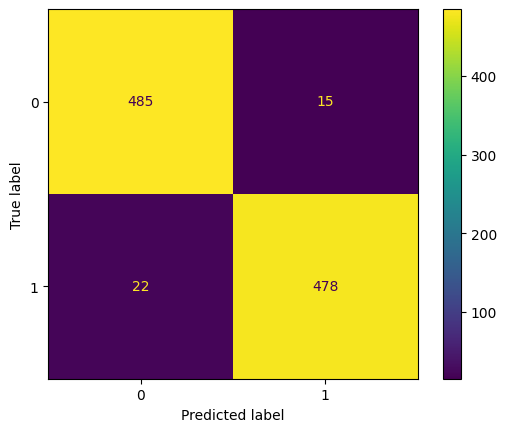

In [8]:
y_pred = sequential_model.predict(X_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, np.round(y_pred))
)
disp.plot()
plt.show()

## Testing

In [9]:
df_testing = pd.read_csv("../parsed_data/RowleyTestSet.csv")
X_test, y_test = encoder(df_testing.SMILES.values), df_testing.covalent.values

23/23 [==============================] - 1s 30ms/step


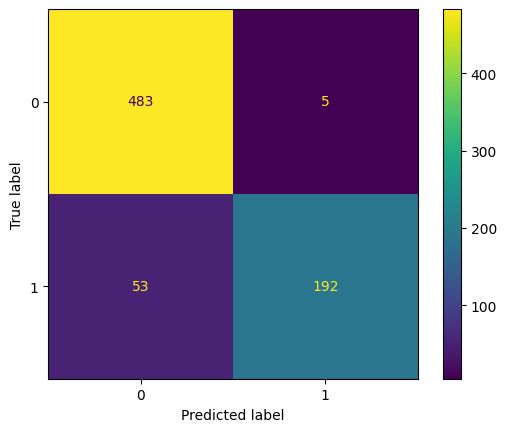

In [10]:
y_pred = sequential_model.predict(X_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, np.round(y_pred))
)
disp.plot()
plt.show()

In [11]:
import os 
from rdkit.Chem import PandasTools
from rdkit import Chem

df_probs = {
        "mol": [],
        "prob": []
}

set_dir = "../parsed_data/non-reactive/"
for file in os.listdir(set_dir):
    if file.endswith(".sdf"):
        df_probs['mol'].append(file)
        df_probs['prob'].append(
                float(
                        sequential_model.predict(
                                encoder(
                                        [PandasTools.LoadSDF(set_dir + file, smilesName="SMILES").SMILES[0]]
                                        )
                                        )
                                        )
                                        )

    

1/1 [==============================] - 0s 197ms/step


In [12]:
a = pd.DataFrame(df_probs)
len(a[a.prob >= 0.5])

14

<AxesSubplot: ylabel='Frequency'>

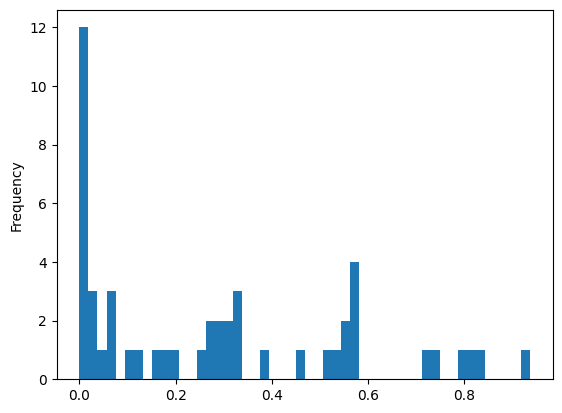

In [13]:
a.prob.plot.hist(bins=50)

In [14]:
# sequential_model.save("MolGraphModelGCN_withEdge_andExtendedFeatures")